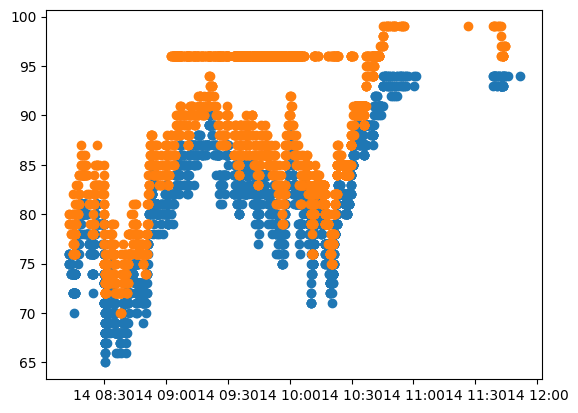

In [23]:
# Plot a market
import matplotlib.pyplot as plt 
data = db.read("INXZ-23SEP14-T4467.44")
ob = [i for i in data]
bbos = [(o.get_bbo(), o.ts) for o in ob]
bids = [(o.bid,ts) for o,ts in bbos if o is not None]
bids = [(o.price, ts) for o, ts in bids if o is not None]
asks =  [(o.ask,ts) for o,ts in bbos if o is not None]
asks = [(o.price,ts) for o,ts in asks if o is not None]
plt.scatter([ts for _, ts in bids], [p for p, _ in bids])
plt.scatter([ts for _, ts in asks], [p for p, _ in asks])
plt.show()

In [1]:
import datetime
####### START HERE ############
from data.coledb.coledb import ColeDBInterface
date = "2023-11-30"
end_time = "16:00:00"  # 4 pm
datetime_str = f"{date} {end_time}"
dt_object = datetime.datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
formatted_date = dt_object.strftime('%y%b%d').upper()
close_time_unix = int(dt_object.timestamp())
filename = f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/bbo_INXZ_and_SPY_{date}.csv"
from data.coledb.coledb import ColeDBInterface
db = ColeDBInterface()
cole_db_path = db.cole_db_storage_path / f"INXZ/{formatted_date}"
market_suffix = list(cole_db_path.iterdir())[0].name
price_threshold = float(market_suffix[1:])*10

In [88]:
# Create file ONLY RUN THIS ONCE
assert False
from strategy.utils import get_spy_ob_bbo_merged_df
from helpers.types.markets import MarketTicker
date_no_hyphen = date.replace("-","")
df = get_spy_ob_bbo_merged_df(db, f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/databento/xnas-itch/spy/xnas-itch-{date_no_hyphen}.mbo.csv", MarketTicker(f"INXZ-{formatted_date}-{market_suffix}"))
df.to_csv(filename)

AssertionError: 

1. first clean data, remove rows with nan spy. Then, divide spy price by 10000000 (to convert to cents). Take all times between 9:30 AM an d 4 PM
2. lag ES data by certain amount of time (maybe 0 seconds, 500 millis, 1 second, 2 seconds, 3 seconds, 4 seconds, 5 seconds, 10 seconds)
3. for each lagged df, tune hyper params 
4. params to tune are: m,b, and shift_up

In [2]:

# Load data (instead of creating)
import pandas as pd

# LOAD DATA
df = pd.read_csv(filename)

# First remove any rows with nan spy (cleaned_df)
cdf = df[df['spy_price'].notna()]
cdf['spy_price'] /= 10000000
cdf = cdf[(cdf.ts >= close_time_unix - 23400) & (cdf.ts <= close_time_unix)]
cdf = cdf[((cdf.yes_bid_price).notna()) & ((cdf.yes_ask_price).notna())]
cdf['spy_price_expanding_std_dev'] = cdf.spy_price.expanding().std()
# Next (skipped) lag the data
...


/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1365/1883981032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['spy_price'] /= 10000000


Ellipsis

In [42]:
import numpy as np
from scipy.optimize import basinhopping, minimize


def get_cdf_with_params(x):
    m = x[0]
    b = x[1]
    shift_up = x[2]
    c = x[3]
    d = x[4]
    """Minimization functions for the bids"""
    diff = close_time_unix - df.ts
    cdf['w'] = m *((diff)**c) + d * diff + b
    cdf['sigmoid'] = (1 / (1 + np.exp(-1*(price_threshold - cdf.spy_price)* (cdf.w)))) + shift_up
    return cdf

def minimize_bids(x):
    cdf = get_cdf_with_params(x)
    # Adjust below for bids (yes_ask_price)
    return abs((100*cdf.sigmoid) - cdf.yes_bid_price).sum()
def callback(x, f=None, accepted= None):
    print(f"Iteration {callback.iteration}: x = {x}, f(x) = {f}, accepted = {accepted}")
    callback.iteration += 1
callback.iteration = 0
# Nelder-Mean method
result = minimize(
        minimize_bids,
        [3.45340156e-06, -1.01846140e-02,  4.92236515e-02,  1.07880840e+00,
 -7.41238138e-06],
        method="Nelder-Mead",
        callback=callback

    )
# Best so far:
# 9/14/23 -- 104577
# 10/02/23 -- 456965
# 10/18/23 -- 170952
# 11/30/23 -- 857148.92
# [3.45340156e-06, -1.01846140e-02,  4.92236515e-02,  1.07880840e+00,-7.41238138e-06]
minimize_bids(result.x)

Iteration 0: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 1: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 2: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 3: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 4: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 5: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 6: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.41238138e-06], f(x) = None, accepted = None
Iteration 7: x = [ 3.45340156e-06 -1.01846140e-02  4.92236515e-02  1.07880840e+00
 -7.4123

857148.920417511

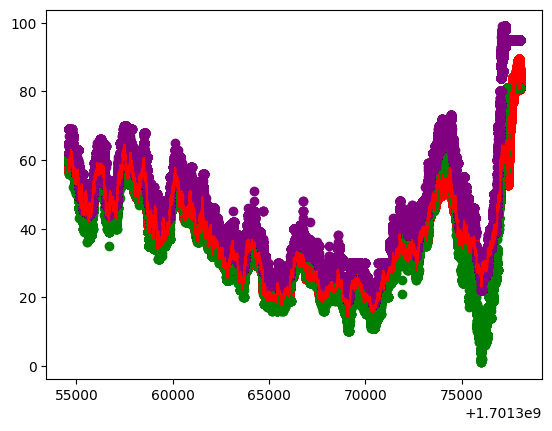

In [43]:
import matplotlib.pyplot as plt 
cdf_with_params = get_cdf_with_params(result.x)

plt.plot(cdf_with_params.ts, cdf_with_params.sigmoid*100, color = 'red')
plt.scatter(cdf_with_params.ts, cdf_with_params.sigmoid*100, color = 'red')
plt.scatter(cdf_with_params.ts, cdf_with_params.yes_bid_price, color ='green')
plt.scatter(cdf_with_params.ts, cdf_with_params.yes_ask_price, color = 'purple')
plt.show()

##### TODO:

1. (done) Figure out good bounds for hyper params -- it's returning the same values everywhere (find out why). You might need to use diff optimizations
2. **TODO** figure out why it's inversely correlated
3. Run for asks as well 
4. Finally, try to lag the data some time 